# 1. Introduction

**add introduction**

# 2. Esthetic evaluation


In order to check whether our methods improve in some sense the quality of the input image, we would need a reliable way to measure the esthetic quality of the picture.

Evaluating quantitatively and computationally the esthetics of a picture is challenging for multiple reasons [1]:
1. complicated photographic rules or abstract art principles
2. variety of image subjects (people, animals, architecture, ...) or genres (portrait, street photography, landscape, ...)
3. knowledge of technical details and camera settings (lighting, sharpness, depth-of-field, motion blur, ...)
4. having sufficiently large datasets of aesthetic evaluation.

## 2.1 Background

Historically, the first attempts at using machine learning for image-quality assessment were done via simple supervised classifiers like SVM, while later it has been tried to employ CNNs with better success [4] (find an example in [this Nvidia blog post](https://developer.nvidia.com/blog/understanding-aesthetics-deep-learning/)). Most recent attempts veered towards self-supervised methods like contrastive learning [5].


## 2.2 Dataset

As dataset we chose to use the [AADB dataset](https://ics.uci.edu/~skong2/aesthetics.html) [2] which is formed of 10000 images with an overall esthetic score and binary labels for 8 attributes - balancing element, colour harmony, interesting content, shallow depth of field, good lightning, object emphasis, rule of thirds, vivid colour - rated manually by 5 experts.

For example, the following image has an overall esthetic score of 0.7

<img src="report_images\farm1_260_20135299762_a988319739_b.jpg" alt="Example image from AADB dataset" width="500"/>

Unfortunately, the dataset doesn't fit on GitHub and we could only get it from the authors upon request. Some cells (clearly marked) of this notebook require the dataset to run, if you wish to re-run those parts by yourself contact us and we will share the dataset via other means.

Since in our analysis we will also need a caption for each image, which the original dataset doesn't have, we used an image-to-text model ([Llama](https://huggingface.co/meta-llama/Meta-Llama-3-8B)) to produce a description of the content of each image.
In the example above that is "Two boys walking through a grassy field, one in front of the other."

All produced captions are contained in dataset\data\aadb_prompts.txt

Notice that we only produced a caption for 1/3 of the dataset, because processing it completely was taking too much time.

## 2.3 Our approach

As a first step, let's first check if current image-generating models have learned, in their training, some sort of concept of esthetics.

To do so, we use a [pre-trained image-to-image model from HuggingFace](https://huggingface.co/runwayml/stable-diffusion-v1-5)

In [ ]:
import torch
from diffusers import StableDiffusionImg2ImgPipeline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pre-trained model
model_id_or_path = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionImg2ImgPipeline.from_pretrained(model_id_or_path, torch_dtype=torch.float16)
pipe = pipe.to(device)

In [ ]:
import requests
from PIL import Image
from io import BytesIO

url = "https://raw.githubusercontent.com/CompVis/stable-diffusion/main/assets/stable-samples/img2img/sketch-mountains-input.jpg"

response = requests.get(url)
init_image = Image.open(BytesIO(response.content)).convert("RGB")
init_image = init_image.resize((768, 512))

prompt1 = "A fantasy landscape, ugly hand sketch"
prompt2 = "A fantasy landscape, Caravaggio painting"

image0 = pipe(prompt=prompt1, image=init_image, strength=0.75, guidance_scale=7.5).images[0]
image1 = pipe(prompt=prompt2, image=init_image, strength=0.75, guidance_scale=7.5).images[0]

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(10, 5))

axs[0,0].imshow(init_image)
axs[0,0].set_title("Initial Image")
axs[0,0].axis('off')
axs[0,1].axis('off')

axs[1,0].imshow(image0)
axs[1,0].set_title("Sketch style")
axs[1,0].axis('off')

axs[1,1].imshow(image1)
axs[1,1].set_title("Caravaggio's style")
axs[1,1].axis('off')

plt.show()

We can see that the model has learned during its training different types of style, so we want to test if the model is able to distinguish between "good" and "bad" looking images and if we can leverage that distinction to define an esthetic metric.

Let's first see more in details what's the structure of the stable diffusion model employed above. Essentially, it consists of three components:
1. an autoencoder (VAE)
2. a U-Net
3. a text encoder (CLIP).

<img src="report_images\stable-diffusion.png" alt="Scheme of the structure of stable diffusion" width="500"/>

If the model has learned a distinction between "good" and "bad" images, that difference should be encoded somehow within the embedding space of VAE's encoder $z$ or in U-Net's embeddings $\hat{z}$.

In the example above, those two embeddings are the following:

In [ ]:
import torchvision.transforms as transforms
from diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_img2img import retrieve_latents

transform = transforms.ToTensor()
tensor_image = transform(init_image).to(device=device, dtype=torch.half).unsqueeze(0)

z = retrieve_latents(pipe.vae.encode(tensor_image))

# Assuming latents is a tensor with shape (batch, latent_channels, width, height)
fig, axs = plt.subplots(2, 2)

# Plotting the four channels separately
for i, ax in enumerate(axs.flat):
    ax.imshow(z[0, i].cpu().detach().numpy(), cmap='gray')
    ax.axis('off')
    ax.set_title(f'Channel {i+1}')

plt.title("VAE's encoder embedding")
plt.show()

In [ ]:
# Change the output type to get U-Net's latent
z_hat = pipe(prompt=prompt2, image=init_image, strength=0.75, guidance_scale=7.5, output_type='latent').images

# Assuming latents is a tensor with shape (batch, latent_channels, width, height)
fig, axs = plt.subplots(2, 2)

# Plotting the four channels separately
for i, ax in enumerate(axs.flat):
    ax.imshow(z_hat[0, i].cpu().detach().numpy(), cmap='gray')
    ax.axis('off')
    ax.set_title(f'Channel {i+1}')

plt.title("U-Net's embedding")
plt.show()

In order to produce U-Net's embedding, captions of the images were required. That's why we run Llama image-to-text model on a portion of the dataset to produce a description of each image. You can find it in `dataset/data/aadb_prompts.txt` which was produced by launching the script `dataset/promptify_images.py`.

U-Net's embeddings for a portion of the dataset were then retrieved using the script `dataset/unet_embeddings.py`. We only did it for a third of the dataset because it was taking too long.

The naif approach to test our hypothesis can be described as follows:
1. We can perform PCA analysis on $z$ and $\hat{z}$ and ideally find a principal component that corresponds to some esthetic quality.
2. If the above fails, we can train a simple binary classifier on embeddings and check if it is able to learn a difference between "good" and "bad" images.

The approach is naif and we don't really expect it to work, since it relies on whether the stable diffusion model learned that difference at all, and also, that difference (if it exists) may well be overshadowed by other noisy factors stemming from the variety of images contained in the dataset. It would have been useful to have a dataset consisting of just one subject, but we couldn't find it. Anyway, despite the naivety, it's worth a try.

### 2.3.1 VAE's encoder embeddings analysis

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
from einops import rearrange
import matplotlib.pyplot as plt

# Load VAE's encoder embeddings and the overall esthetic score
latents = np.load('dataset/data/saved/vae_latents.npy')
scores = np.load('dataset/data/saved/scores.npy')

# Split the dataset into train and test
train_size = int(len(latents) * 0.8)
embeds = rearrange(latents, 'b c w h -> b (c w h)')
train_embeds = embeds[:train_size, :]
test_embeds = embeds[train_size:, :]

# Fit PCA on the training set
pca = PCA(n_components=10)
pca.fit(train_embeds)

# Transform the embeddings
embeds_pca = pca.transform(test_embeds)
test_scores = scores[train_size:]

# Plot the explained variance ratio
plt.title("Explained variance ratio")
plt.plot(pca.explained_variance_ratio_)
plt.show()

As you can see from the plot, each principal component is able to capture quite a small portion of the variance, a symptom of the fact that the encoder's embedding space doesn't manage to disentangle well enough all different sources of variance, as expected.

We can also try to exacerbate the distinction between bad and pretty images by considering only images with scores lower than 0.2 and higher than 0.8.

In [ ]:
ugly_idx = test_scores < 0.2
pretty_idx = test_scores > 0.8

ugly_img = embeds_pca[ugly_idx]
pretty_img = embeds_pca[pretty_idx]

plt.figure(figsize=(12, 6))

# Plotting the histogram for "ugly" images
plt.subplot(1, 2, 1)
plt.hist2d(ugly_img[:, 0], ugly_img[:, 1], bins=50, cmap='Blues')
plt.colorbar(label='Frequency')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('Histogram of "Ugly" Images')
plt.xlim(np.min(embeds_pca[:, 0]), np.max(embeds_pca[:, 0]))
plt.ylim(np.min(embeds_pca[:, 1]), np.max(embeds_pca[:, 1]))

# Plotting the histogram for "pretty" images
plt.subplot(1, 2, 2)
plt.hist2d(pretty_img[:, 0], pretty_img[:, 1], bins=50, cmap='Reds')
plt.colorbar(label='Frequency')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('Histogram of "Pretty" Images')
plt.xlim(np.min(embeds_pca[:, 0]), np.max(embeds_pca[:, 0]))
plt.ylim(np.min(embeds_pca[:, 1]), np.max(embeds_pca[:, 1]))

plt.tight_layout()
plt.show()

It doesn't seem like there is a clear distinction at this stage between ugly and pretty images.

Let's try with a classifier:

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

pretty_idx = scores > 0.5

# Split the data into train and test sets
embeds = rearrange(latents, 'b c w h -> b (c w h)')
X_train, X_test, y_train, y_test = train_test_split(embeds, pretty_idx, test_size=0.2, random_state=42)

# Create a logistic regression classifier
classifier = LogisticRegression(max_iter=1000)

# Train the classifier
classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

As expected, the accuracy is not great, meaning that indeed at this stage the model is not able to distinguish between pretty and ugly images.

### 2.3.2 U-Net's embeddings analysis

Let's try the same analysis on U-Net's embeddings instead

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
from einops import rearrange
import matplotlib.pyplot as plt

# Load U-Net's embeddings and the overall esthetic score
latents = np.load('dataset/data/saved/unet_latents.npy')
scores = np.load('dataset/data/saved/scores.npy')

# Check for NaN values in latents
nan_mask = np.isnan(latents)

# Replace NaN values with random numbers
n_latents = latents.copy()
n_latents[nan_mask] = np.random.rand(np.sum(nan_mask))

# Split the dataset into train and test
train_size = int(len(n_latents) * 0.8)
embeds = rearrange(n_latents, 'b c w h -> b (c w h)')
train_embeds = embeds[:train_size, :]
test_embeds = embeds[train_size:, :]

# Fit PCA on the training set
pca = PCA(n_components=10)
pca.fit(train_embeds)

# Transform the embeddings
embeds_pca = pca.transform(test_embeds)
scores = scores[:len(latents)]
test_scores = scores[train_size:]

# Plot the explained variance ratio
plt.title("Explained variance ratio")
plt.plot(pca.explained_variance_ratio_)
plt.show()

In [ ]:
ugly_idx = test_scores < 0.5
pretty_idx = test_scores > 0.5

ugly_img = embeds_pca[ugly_idx]
pretty_img = embeds_pca[pretty_idx]

plt.figure(figsize=(12, 6))

# Plotting the histogram for "ugly" images
plt.subplot(1, 2, 1)
plt.hist2d(ugly_img[:, 0], ugly_img[:, 1], bins=50, cmap='Blues')
plt.colorbar(label='Frequency')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('Histogram of "Ugly" Images')
plt.xlim(np.min(embeds_pca[:, 0]), np.max(embeds_pca[:, 0]))
plt.ylim(np.min(embeds_pca[:, 1]), np.max(embeds_pca[:, 1]))

# Plotting the histogram for "pretty" images
plt.subplot(1, 2, 2)
plt.hist2d(pretty_img[:, 0], pretty_img[:, 1], bins=50, cmap='Reds')
plt.colorbar(label='Frequency')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('Histogram of "Pretty" Images')
plt.xlim(np.min(embeds_pca[:, 0]), np.max(embeds_pca[:, 0]))
plt.ylim(np.min(embeds_pca[:, 1]), np.max(embeds_pca[:, 1]))

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

pretty_idx = scores > 0.5

# Split the data into train and test sets
embeds = rearrange(n_latents, 'b c w h -> b (c w h)')
X_train, X_test, y_train, y_test = train_test_split(embeds, pretty_idx, test_size=0.2, random_state=42)

# Create a logistic regression classifier
classifier = LogisticRegression(max_iter=1000)

# Train the classifier
classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

It seems that also the Unet embeddings do not represent the difference between ugly and pretty images in an explicit way.

Another approach that we attempted, but we don't report here for brevity, was to modify the description of the images so as to accentuate the skewness of the U-Net's embeddings between ugly and pretty images. For example, by adding strings like "professional/amateur photography". But it didn't help either.

Probably the pre-trained model that we used is not expressive enough to grasp the difference in esthetic quality. A possible way to fix this, which goes beyond the scopes of this course, is to replace the pre-trained VAE with another one, trained specifically on the task, maybe based on $\beta$-VAE [3], so that ideally one gets an "esthetic direction" in the embedding space.

In conclusion, our attempt at finding a way to quantitatively measure the esthetic quality of an image failed, so in the rest of the project we will rely on our subjective opinion to assess if our take at using geneerative AI tools to improve pictures actually works.

# Reframing pipeline


The reframing pipeline's objective is to identify the subject within an image and then modify the image accordingly. This modification involves shifting and zooming to align the subjects with the thirds. In the process of shifting and zooming, parts of the image that were previously outside the frame may become visible. To ensure a complete and visually appealing image, these newly visible areas are filled in using an image restoration technique known as inpainting. Inpainting effectively reconstructs the lost or deteriorated parts of the image, resulting in a well-framed and complete image. To use this pipeline run main.py but need first define path to image.

## Some terms used

(ADD terms here)

## AI models used in the pipeline

(Add AI models here, objecte detection, cloating detection, Inpaint)

object detection
https://huggingface.co/facebook/detr-resnet-50

cloathing detection
https://huggingface.co/mattmdjaga/segformer_b2_clothes

Inpaint
https://huggingface.co/docs/diffusers/api/pipelines/stable_diffusion/inpaint

## Flowchart of reframing pipeline
![Alt text](Diagrams/reframing_flowchart.png)

## Some Example
(Take an example image with multiple objects and run it using differnet focus, some where Inpaint is needed and some where it isnt)

In [30]:
#temporary cell to reload reframe
import reframe
import importlib
importlib.reload(reframe)

<module 'reframe' from 'c:\\Users\\remik\\GitHub\\gen-ai-photography\\reframe.py'>

In [31]:
from reframe import *
from infill import Infill
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

Using an example image I took of myself

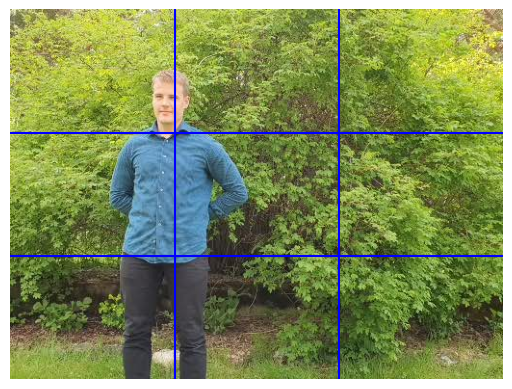

In [32]:
#Set the path to the image
Example_image_path ="Example_images\Example_person.png"

Example_image = Image.open(Example_image_path)
width, height = Example_image.size

plt.imshow(Example_image)
plt.axis('off')
Draw_thirds(height, width)
plt.show()

In the example we see that the face does not perfectly line up with any of the thirds, biut is very close to to the top left one

First we will see what the object detection sees

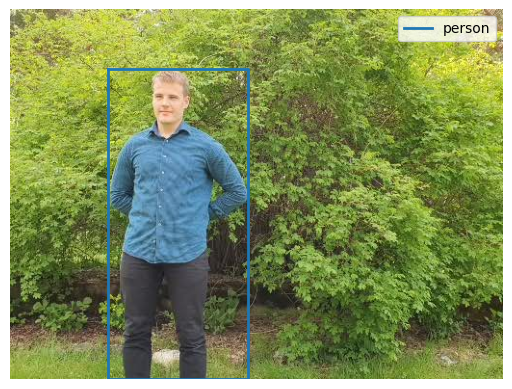

In [33]:
Display_object_detection(Example_image)

Here we see that the object detection has correctly detected the peerson in the image. Since we are reframing for a person the pipline would take the person path as seen in the flowchart.

c:\Users\remik\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\models\segformer\image_processing_segformer.py:103: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


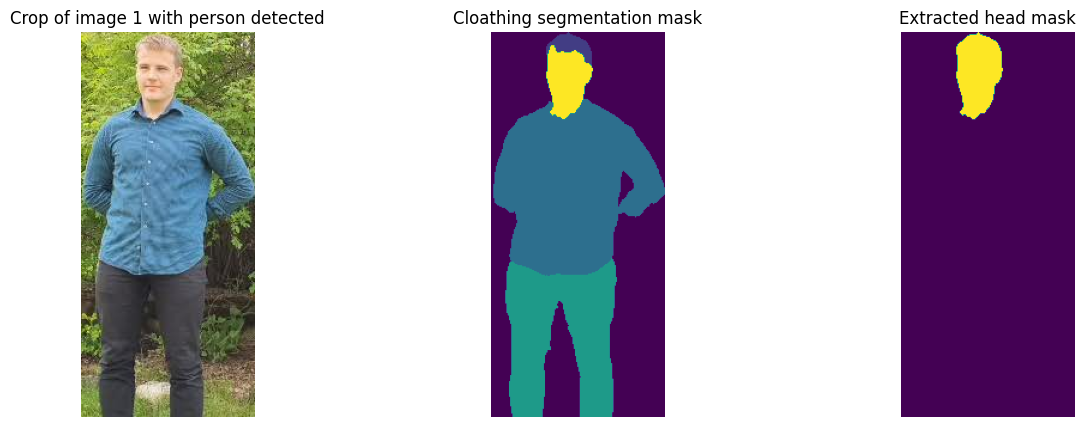

In [41]:

person_images, boxes = crop_subjects(Example_image, "person",return_boxes = True)
person_image = person_images[0]
box = boxes[0]

fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns

# Assuming person_image1, person_image2, person_image3 are your images
axs[0].imshow(person_image)
axs[0].set_title("Crop of image 1 with person detected")
axs[0].axis('off')


head_pos,seg, mask =  get_person_cordinate(person_image, return_segmentation = True, return_head_segmentation = True)



axs[1].imshow(seg)
axs[1].set_title("Cloathing segmentation mask")
axs[1].axis('off')

axs[2].imshow(mask)
axs[2].set_title("Extracted head mask")
axs[2].axis('off')

plt.show()


From the head segmentation it calculates the avredge position of the headsegmentation to get an estimated center of head

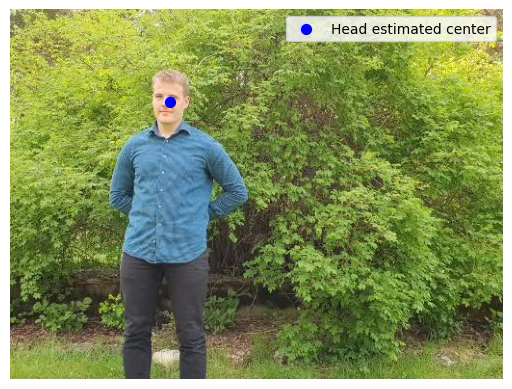

In [51]:
head_pos_Example_image = (head_pos[0] + box[1], head_pos[1] + box[0])

plt.imshow(Example_image)
plt.axis('off')
plt.scatter(head_pos_Example_image[1], head_pos_Example_image[0], c='b', s=50, label='Head estimated center')
plt.legend()
plt.show()

Now the algorithm can shift the image such that the center of the head matches the closest third

In [ ]:
reframed_Example_image, Example_image_mask = refram_to_thirds(Image, Subject = None, Return_mask = True)

## Discussing result of reframing pipeline

# References

1. Zhang, Jiajing, Yongwei Miao, and Jinhui Yu. "A comprehensive survey on computational aesthetic evaluation of visual art images: Metrics and challenges." IEEE Access 9 (2021): 77164-77187.
2. Kong, Shu, et al. "Photo aesthetics ranking network with attributes and content adaptation." Computer Vision–ECCV 2016: 14th European Conference, Amsterdam, The Netherlands, October 11–14, 2016, Proceedings, Part I 14. Springer International Publishing, 2016.
3. Higgins, Irina, et al. "beta-vae: Learning basic visual concepts with a constrained variational framework." ICLR (Poster) 3 (2017).
4. Deng, Yubin, Chen Change Loy, and Xiaoou Tang. "Image aesthetic assessment: An experimental survey." IEEE Signal Processing Magazine 34.4 (2017): 80-106.
5. Yang, Shuai, et al. "A self-supervised image aesthetic assessment combining masked image modeling and contrastive learning." Journal of Visual Communication and Image Representation (2024): 104184.